# **RESTRICTED BOLTZMANN MACHINES**

### **Load Required Libraries**

In [1]:
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### **Load and Preprocess the Iris Dataset**

In this dataset:
+ **Iris features**: 4 features (sepal length, sepal width, petal length, petal width)
+ **Number of classes**: 3 (but we will ignore class information for RBM training)

In [2]:
iris = load_iris()
data = iris.data
target = iris.target

scaler = StandardScaler()
data = scaler.fit_transform(data)

data = tf.constant(data, dtype=tf.float32)

### **Define RBM Layers**

In [3]:
V = 4  # Number of features in data
H = 3  # Number of hidden units

# biases and weights
v_bias = tf.Variable(tf.zeros([V]), tf.float32) # Bias for visible units (features).
h_bias = tf.Variable(tf.zeros([H]), tf.float32) # Bias for hidden units.
W = tf.Variable(tf.random.normal([V, H], stddev=1.0, dtype=tf.float32))

### **Define Forward and Backward Pass Functions**

In [4]:
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.nn.sigmoid(tf.matmul(v0_state, W) + hb)
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob))))
    return h0_state

def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb)
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob))))
    return v1_state

hidden_layer: Calculates probabilities of hidden layer units given the visible units.
+ h0_prob: Probability of hidden units being active.
+ h0_state: Binary state of hidden units (activated or not).

reconstructed_output: Reconstructs the visible layer from the hidden layer.
+ v1_prob: Probability of visible units being active after reconstruction.
+ v1_state: Binary state of reconstructed visible units.

### **Define the Error Function**

Computes the reconstruction error between the original visible state and the reconstructed visible state. This is used to gauge the performance of the RBM.

In [5]:
def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))

### **Training the Model**

In [6]:
learning_rate = 0.001
epochs = 2
batchsize = 30 
K = 1   # No. of Gibbs sampling steps
errors = []

# Creating dataset from the Iris data and batching it.
train_ds = tf.data.Dataset.from_tensor_slices(data).batch(batchsize)

for epoch in range(epochs):
    for batch_x in train_ds:
        for i_sample in range(batchsize):
            for k in range(K):
                v0_state = batch_x[i_sample:i_sample+1] # Original visible layer.
                h0_state = hidden_layer(v0_state, W, h_bias)
                v1_state = reconstructed_output(h0_state, W, v_bias)    # Reconstructed visible state.
                h1_state = hidden_layer(v1_state, W, h_bias)

                delta_W = tf.matmul(tf.transpose(v0_state), h0_state) - tf.matmul(tf.transpose(v1_state), h1_state)
                W.assign_add(learning_rate * delta_W)

                v_bias.assign_add(learning_rate * tf.reduce_mean(v0_state - v1_state, 0))
                h_bias.assign_add(learning_rate * tf.reduce_mean(h0_state - h1_state, 0))

                v0_state = v1_state

            if i_sample == batchsize-1:
                err = error(batch_x[i_sample:i_sample+1], v1_state)
                errors.append(err.numpy())
                print('Epoch: %d' % epoch, 'sample #: %i' % i_sample, 'reconstruction error: %f' % err.numpy())

Epoch: 0 sample #: 29 reconstruction error: 4.114938
Epoch: 0 sample #: 29 reconstruction error: 1.641178
Epoch: 0 sample #: 29 reconstruction error: 1.720338
Epoch: 0 sample #: 29 reconstruction error: 2.332407
Epoch: 0 sample #: 29 reconstruction error: 0.346549
Epoch: 1 sample #: 29 reconstruction error: 2.264539
Epoch: 1 sample #: 29 reconstruction error: 0.979894
Epoch: 1 sample #: 29 reconstruction error: 1.720338
Epoch: 1 sample #: 29 reconstruction error: 2.332407
Epoch: 1 sample #: 29 reconstruction error: 0.030559


### **Visualize Training Errors**

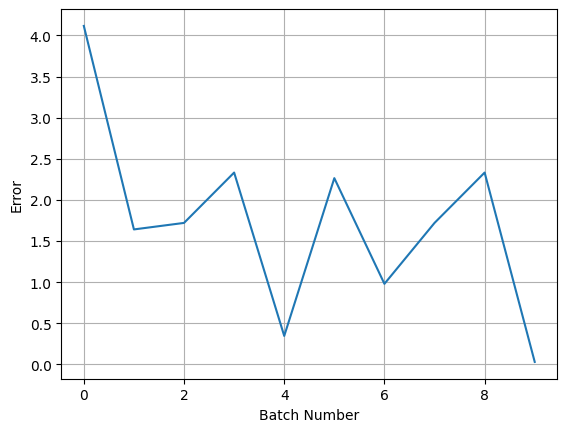

In [7]:
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.grid()
plt.show()